# Oxford pet

Is a dataset where there are pictures of animals. Each pixel is labeled in such system:

- 0: animal.
- 1: backgroud.
- 2: border.

In [4]:
import os
import wandb
import numpy as np
from tqdm import tqdm
from pathlib import Path
from typing import Callable
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms as T
from torchvision.datasets import OxfordIIITPet

import huggingface_hub

hf_api = huggingface_hub.HfApi()
def save_model(model: torch.nn.Module, model_name: str):
    with TemporaryDirectory() as tmpdir:
        torch.save(model.state_dict(), Path(tmpdir)/model_name)
        hf_api.upload_folder(
            repo_id="fedorkobak/knowledge",
            folder_path=tmpdir
        )

def  load_model(model: torch.nn.Module, model_name: str):
    cached_model = huggingface_hub.hf_hub_download(
        repo_id="fedorkobak/knowledge",
        filename=model_name
    )
    model.load_state_dict(
        torch.load(cached_model, map_location=torch.device('cpu')),
    )
    return model


if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")
print("using device", DEVICE)


# Determining where the notebook is run and the corresponding setup. If 
# necessary, load all required credentials.
runned_in_free_server = False

if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    print("Runned in Kaggle")
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    wandb_token = user_secrets.get_secret("wandb_token")
    hf_token = user_secrets.get_secret("hf_token")
    runned_in_free_server = True

elif 'COLAB_GPU' in os.environ:
    print("Runned in colab")
    from google.colab import userdata
    
    wandb_token = userdata.get("wandb_token")
    hf_token = userdata.get("hf_token")
    runned_in_free_server = True

if runned_in_free_server:
    !wget https://raw.githubusercontent.com/fedorkobak/knowledge/refs/heads/main/python/torch/examples/unet/unet.py
 
    wandb.login(key=wandb_token)
    del wandb_token
    
    huggingface_hub.login(hf_token)
    del hf_token

from unet import DoubleConv, Down, Up

using device cpu


Model.

In [5]:
class UNet(nn.Module):
    """
    Implementation of the final network.
    """

    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()

        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, out_channels=32)
        self.down1 = Down(in_channels=32, out_channels=64)
        self.down2 = Down(in_channels=64, out_channels=128)
        self.down3 = Down(in_channels=128, out_channels=256)

        self.bottleneck = Down(in_channels=256, out_channels=256)

        # Input Up layer is concatenation by channels of the previous layer
        # and corresponding down layer
        self.up1 = Up(in_channels=512, out_channels=128)
        self.up2 = Up(in_channels=256, out_channels=64)
        self.up3 = Up(in_channels=128, out_channels=32)
        self.up4 = Up(in_channels=64, out_channels=32)

        # The last layer applies a convolution that preserves the dimensionality
        # of the feature maps and returns as many channels as the number of
        # predicted classes.
        self.outc = torch.nn.Conv2d(
            in_channels=32,
            out_channels=n_classes,
            kernel_size=1
        )

    def forward(self, x):
        x1 = self.inc(x=x)
        x2 = self.down1(x=x1)
        x3 = self.down2(x=x2)
        x4 = self.down3(x=x3)
        x5 = self.bottleneck(x=x4)
        x = self.up1(x=x5, x_left=x4)
        x = self.up2(x=x, x_left=x3)
        x = self.up3(x=x, x_left=x2)
        x = self.up4(x=x, x_left=x1)
        logits = self.outc(x)
        return logits

## OxfordIIIPet

Consider how model performs on the `OxfotdIIIPet` dataset.

Here is an example of a sample that we will use for model fitting.

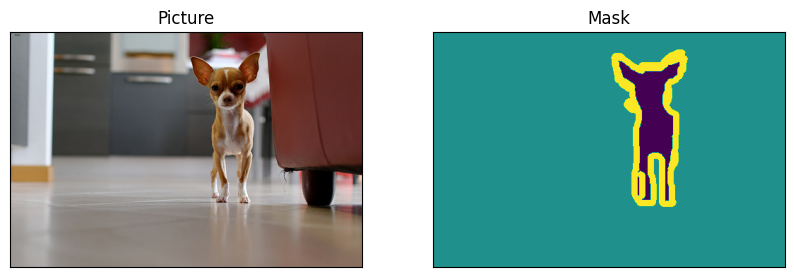

In [7]:
train_dataset = OxfordIIITPet(
    str("OxfordIIITPet"),
    target_types = "segmentation",
    download = True
)
test_dataset = OxfordIIITPet(
    str("OxfordIIITPet"),
    target_types = "segmentation",
    download = True,
    split = "test"
)

test_picture_index = 500

plt.figure(figsize = (10, 9))
plt.subplot(121)
plt.imshow(train_dataset[test_picture_index][0])
plt.xticks([]);plt.yticks([])
plt.title("Picture")

plt.subplot(122)
plt.imshow(train_dataset[test_picture_index][1])
plt.xticks([]);plt.yticks([])
plt.title("Mask")

plt.show()

### Transfomations

The network does not understand images. So we have to create tensors from images. Here we have added some transformations to our dataset. Let's see what they do.

In [8]:
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Lambda(lambda x: x.to(DEVICE))
])
target_transfrom = T.Compose([
    T.Resize((256, 256)),
    T.PILToTensor(),
    # Classes are marked starting with 1 but in python it's easier to work with
    # with sets that start with 0, so the following transformation fixes this
    # inconvenience
    T.Lambda(lambda x: (x - 1).long()),
    # PILToTensor returns an image with an extra dimension for channels,
    # but the target has only one channel, so we don't need that extra dimension.
    T.Lambda(lambda x: x.squeeze()),
    T.Lambda(lambda x: x.to(DEVICE))
])

transforms = torchvision.datasets.vision.StandardTransform(
    transform, target_transfrom
)

train_dataset.transforms = transforms
test_dataset.transforms = transforms

This is the shape of the tensor used as input to the model - it's regular three channel picture.

In [9]:
train_dataset[test_picture_index][0].shape

torch.Size([3, 256, 256])

This is the shape and unique values that appear in the target. So it's just an array whose shape is the same as the shape of the input images, but it only takes three values.

In [10]:
print("Shape:", list(train_dataset[test_picture_index][1].shape))
print("Values:", list(train_dataset[test_picture_index][1].unique()))

Shape: [256, 256]
Values: [tensor(0), tensor(1), tensor(2)]


### Model fitting


In [ ]:
@torch.inference_mode
def evaluate(
    model: UNet,
    loader: DataLoader,
    loss_fun: Callable,
    tqdm_desc: str = None
) -> tuple[float, float]:

    model.eval()

    total_pixels = 0
    correct_pixels = 0
    loss_cumulative = 0

    for X, y in tqdm(loader, desc=tqdm_desc):

        predict = model(X)

        loss_cumulative += loss_fun(input=predict, target=y).item()

        correct_pixels += (predict.argmax(dim=1) == y).sum()
        total_pixels += y.numel()

    return correct_pixels/total_pixels, loss_cumulative/len(loader)

def run_epoch(
    model: UNet,
    loader: DataLoader,
    loss_fun: Callable,
    optimizer: torch.optim.Optimizer
):
    model.train()
    for X, y in tqdm(loader, desc="Fitting"):
        optimizer.zero_grad()
        predict = model(X)
        loss_value = loss_fun(input=predict, target=y)
        loss_value.backward()
        optimizer.step()

Model fitting is complicated thing the best fitting algorithm is represented below.

In [ ]:
torch.manual_seed(20)

model = UNet(n_channels=3, n_classes=3)
model.to(DEVICE)

batch_size = 8
learning_rate = 1e-3

wandb.init(
    project="OxfordPetsUNet",
    config={
        "batch_size": batch_size,
        "learning_rate": learning_rate
    }
)

loss_fun = torch.nn.functional.cross_entropy
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

try:
    for epoch in range(50):

        run_epoch(
            model=model,
            loader=train_loader,
            loss_fun=loss_fun,
            optimizer=optimizer
        )
        train_accuracy, train_loss = evaluate(
            model=model,
            loader=train_loader,
            loss_fun=loss_fun,
            tqdm_desc="Evaluate train"
        )
        test_accuracy, test_loss = evaluate(
            model=model,
            loader=test_loader,
            loss_fun=loss_fun,
            tqdm_desc="Evaluate test"
        )

        wandb.log(
            {
                "train_loss": train_loss,
                "test_loss": test_loss,
                "train_accuracy": train_accuracy,
                "test_accuracy": test_accuracy
            },
            step=epoch
        )
except KeyboardInterrupt:
    pass

Save model to the hugging face.

In [ ]:
save_model(model=model, model_name="unet_model.pt")

unet_model.pt:   0%|          | 0.00/69.3M [00:00<?, ?B/s]

### Visual benchmark

Formal bemchmark is great but who actually cares what number you scored - let's check on picutres. Everyone will draw their own conclusions about the quality of the model.

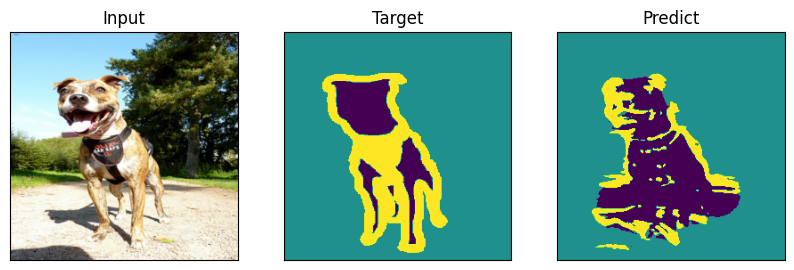

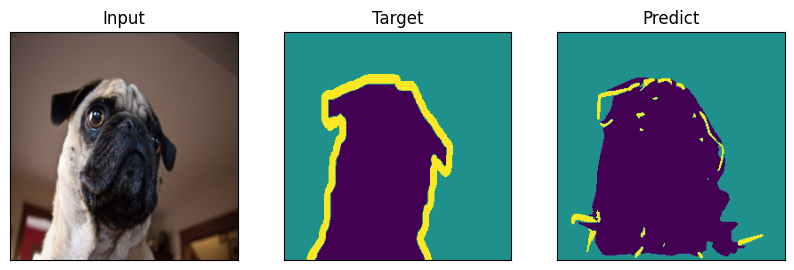

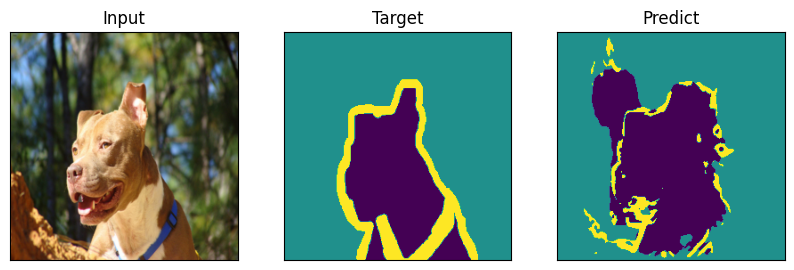

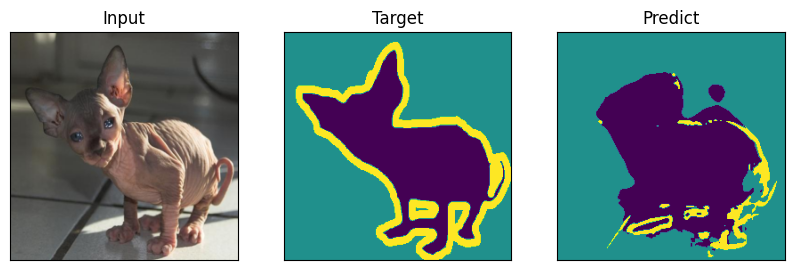

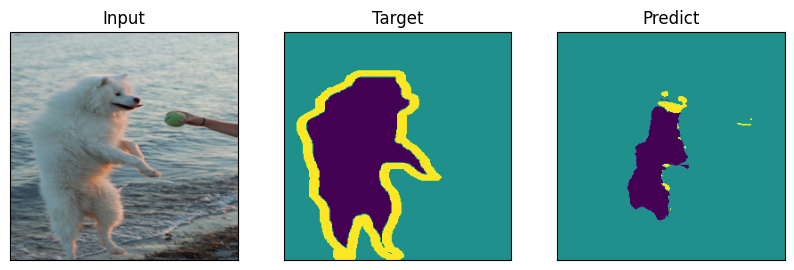

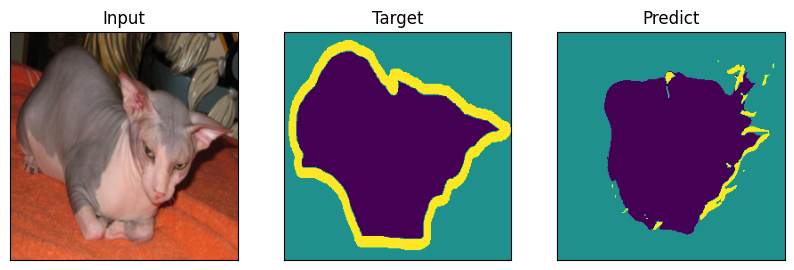

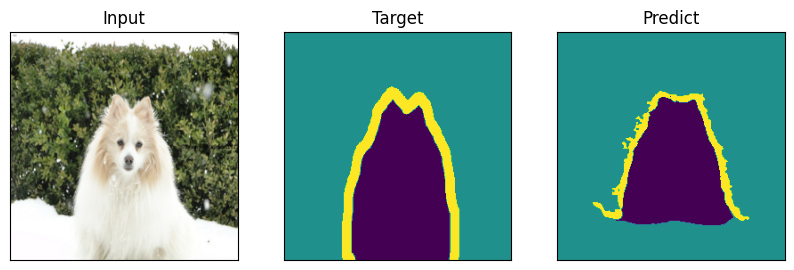

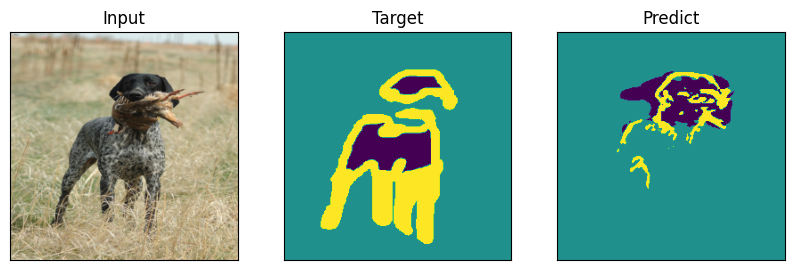

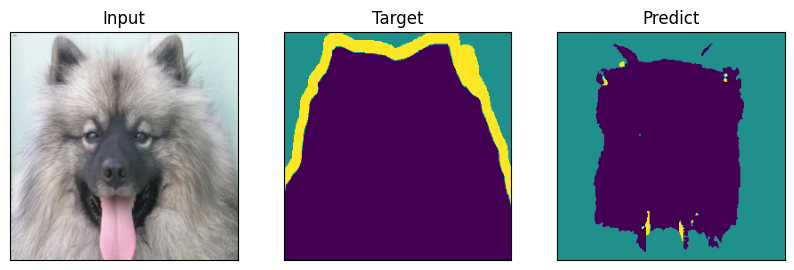

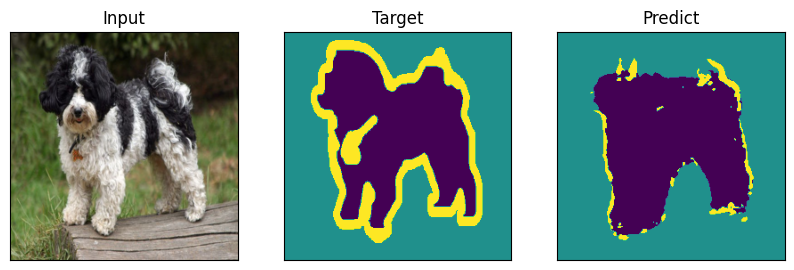

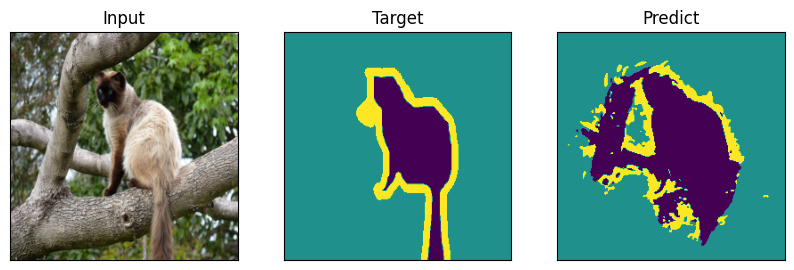

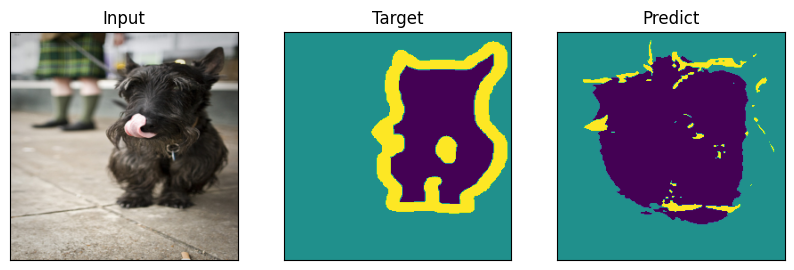

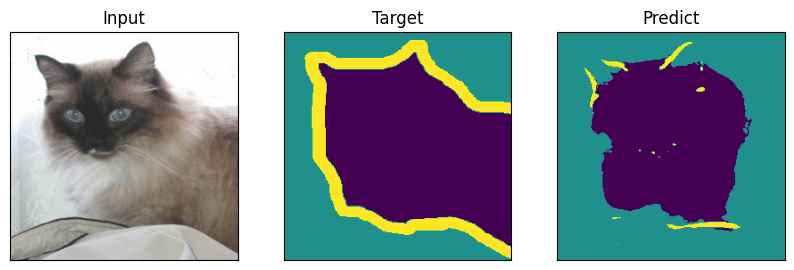

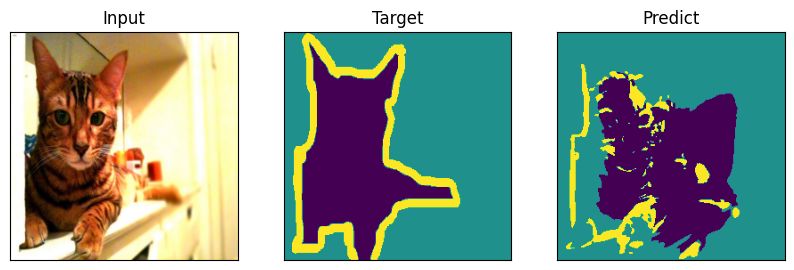

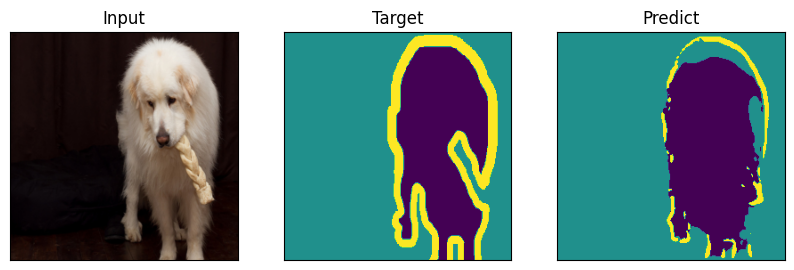

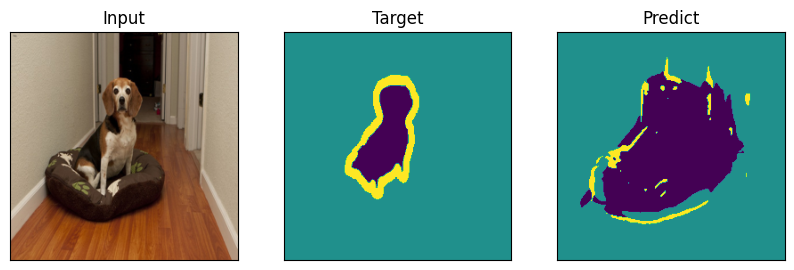

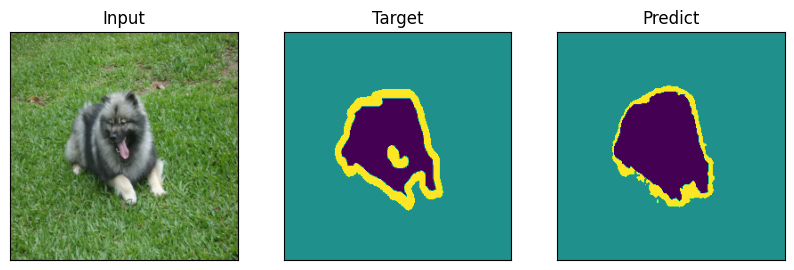

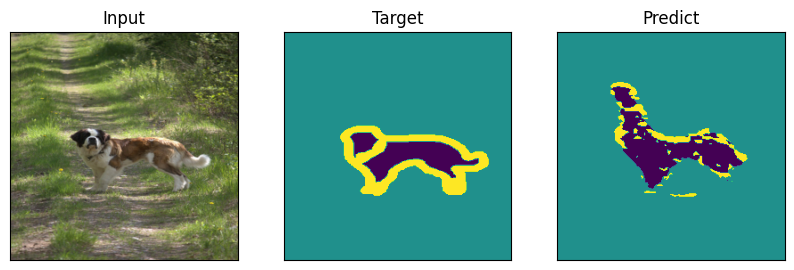

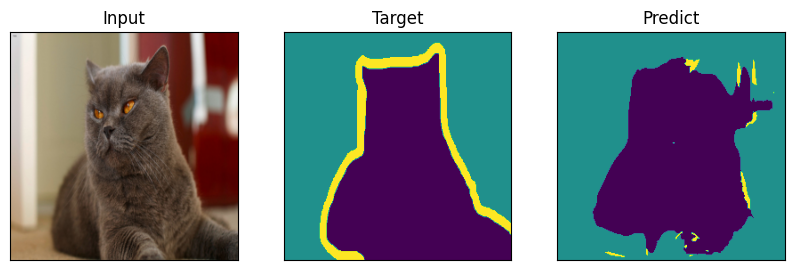

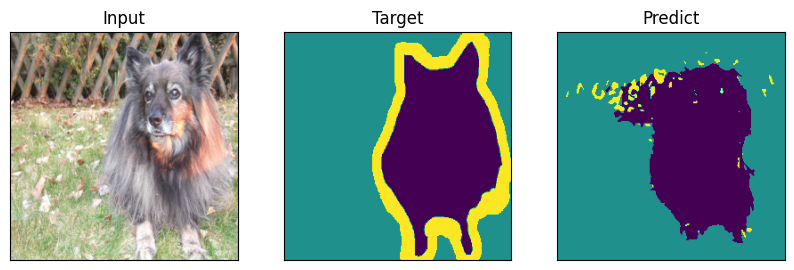

In [11]:
# importing the model
model = UNet(n_channels=3, n_classes=3)
load_model(model=model, model_name="unet_model.pt")

model = model.eval()

np.random.seed(20)

indx = np.random.randint(0, len(test_dataset), 20)

inputs = torch.stack([test_dataset[i][0] for i in indx])
targets = torch.stack([test_dataset[i][1] for i in indx]).to(torch.uint8)
predicts = model(inputs).max(dim = 1)[1].to(torch.uint8)

def plot_result(model_input, target, predict):
    plt.figure(figsize = (10, 9))

    plt.subplot(131)
    plt.title("Input")
    plt.imshow(T.ToPILImage()(model_input))
    plt.xticks([]);plt.yticks([])

    plt.subplot(132)
    plt.title("Target")
    plt.imshow(T.ToPILImage()(target))
    plt.xticks([]);plt.yticks([])

    plt.subplot(133)
    plt.title("Predict")
    plt.imshow(T.ToPILImage()(predict))
    plt.xticks([]);plt.yticks([])

    plt.show()

for i in range(len(indx)):
    plot_result(inputs[i], targets[i], predicts[i])